In [499]:
from nltk.corpus import wordnet as wn
import nltk
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import altair as alt
from numpy import dot
from numpy.linalg import norm
import statistics

In [388]:
import spacy

In [389]:
nlp = spacy.load('en_core_web_md')

In [390]:
mapsFns = ['../data/maps/xkcd/rgb-termsonly.txt', 
           '../data/maps/jaffer/master-termsonly.txt',
           '../data/maps/pantone/pantone-termsonly.txt']
mapsRaw = [open(f).read() for f in mapsFns] 

In [391]:
mapsDocs = [nlp(f) for f in mapsRaw] 

In [392]:
def getHyponyms(synset):
    tree = synset.tree(lambda w: w.hyponyms())
    lemmas = []
    def walkTree(tree): 
        for item in tree: 
            if type(item) == nltk.corpus.reader.wordnet.Synset:
                itemLemmas = item.lemma_names()
                for lemma in itemLemmas: 
                    lemmas.append(lemma)
            else: 
                walkTree(item)
    walkTree(tree)
    cleanLemmas = [w.replace('_', ' ') for w in lemmas]
    joinedLemmas = ', '.join(cleanLemmas)
    return joinedLemmas

In [393]:
seeds = ['fruit', 'food', 'tree', 'flower', 'wine', 'happiness', 'sadness', 'pasta', 'leisure', 'beach', 'snot', 'blood']
#categoryDocs = [nlp(getHyponyms(wn.synsets(w)[0])) for w in seeds]
categoryDocs = [nlp(w) for w in seeds]

In [394]:
pca = PCA(n_components=2)

In [395]:
mapLabels = ['xkcd', 'jaffer', 'pantone'] 
labels = mapLabels + seeds 
docs = mapsDocs + categoryDocs
vecs = [doc.vector for doc in docs]
docDict = dict(zip(labels, docs))
vecDict = dict(zip(labels, vecs))
docDf = pd.DataFrame(vecDict)

In [396]:
df = docDf.T

In [397]:
pcaOut = pca.fit_transform(df)

In [398]:
df = pd.DataFrame(pcaOut, index=labels, columns=['C0', 'C1'])

In [399]:
df['label'] = df.index

In [400]:
df

,C0,C1,label
xkcd,0.542265,0.312949,xkcd
jaffer,0.618431,0.319613,jaffer
pantone,0.453921,0.348965,pantone
fruit,-2.958526,0.001786,fruit
food,-2.491033,-1.296629,food
tree,0.082447,2.628681,tree
flower,-0.059653,2.747052,flower
wine,-3.689976,-1.029401,wine
happiness,3.192172,-0.972847,happiness
sadness,4.043705,-2.249995,sadness


In [401]:
points = alt.Chart(df).mark_circle().encode(x='C0', y='C1')

In [402]:
text = points.mark_text(align='left', dx=7).encode(text='label')

In [403]:
points + text

alt.LayerChart(...)

In [404]:
allSimilarities = {}
for mapLabel in mapLabels: 
    similarities = {catLabel: docDict[mapLabel].similarity(docDict[catLabel]) for catLabel in seeds}
    allSimilarities[mapLabel] = similarities

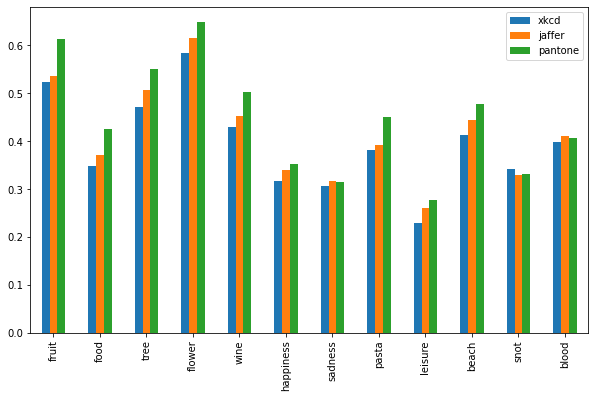

In [405]:
pd.DataFrame(allSimilarities).plot(kind='bar', figsize=(10,6))

In [406]:
def mostSimilar(vec):
    highestSimilarities = [0]
    highestWords = [""]
    for w in nlp.vocab:
        sim = similarity(vec, w.vector)
        if sim > highestSimilarities[-1]:
            highestSimilarities.append(sim)
            highestWords.append(w.text.lower())
    return list(zip(highestWords, highestSimilarities))[-10:]

In [407]:
def similarity(vecA, vecB):
    return dot(vecA, vecB) / (norm(vecA, ord=2) * norm(vecB, ord=2))

In [493]:
highestDeltas = [(0,0,0)]
def findOutliers(colorMapDocs, vocab): 
    """ Find seed words for which a map is very distinctive. """
    for i, w in enumerate(vocab): 
        if w.is_alpha: 
            sims = []
            for mapDoc in colorMapDocs: 
                sim = mapDoc.similarity(w)
                sims.append(sim)
            gap = biggestGap(sims)
            if gap > highestDeltas[-1][2]: 
                outlier = getOutlier(sims) 
                highestDeltas.append((w.text, outlier, gap))
            print(f'Calculating similarity for word {i}: {highestDeltas[-1]}', end='\r')
    return highestDeltas

In [494]:
len(nlp.vocab)

1340904

In [495]:
nlp.vocab

In [496]:
# Too many warnings
import warnings
warnings.filterwarnings('ignore')

In [497]:
sortedVocab = sorted(nlp.vocab, key=lambda x: x.prob, reverse=True)

In [508]:
sims = findOutliers(mapsDocs, sortedVocab)

KeyboardInterrupt: 

In [512]:
[d for d in highestDeltas if d[1] == 0] # XKCD Words

[(0, 0, 0),
 ('I', 0, 0.01945777263683096),
 ('best', 0, 0.02326421694138614),
 ('world', 0, 0.027754587253570273),
 ('family', 0, 0.029002060185731038),
 ('American', 0, 0.04970384663449012),
 ('America', 0, 0.051176016257521995),
 ('Australia', 0, 0.05126372903480553),
 ('Texas', 0, 0.051940818022925384),
 ('San', 0, 0.05349523922698457),
 ('France', 0, 0.05383061022777608),
 ('Florida', 0, 0.05675719486481218),
 ('Michigan', 0, 0.05765549080023852),
 ('Oregon', 0, 0.059314361835722695),
 ('Utah', 0, 0.06286563503523912),
 ('I', 0, 1.1422871699421695),
 ('was', 0, 1.1536744068589875),
 ('him', 0, 1.1543534858255107),
 ('doing', 0, 1.1546869821798802),
 ('gone', 0, 1.1546996521521755),
 ('hurt', 0, 1.1546998896013714),
 ('tax', 0, 1.154700534494641),
 ('archives', 0, 1.154700538285313)]

In [513]:
[d for d in highestDeltas if d[1] == 1] # Jaffer words

[('at', 1, 1.1542988456454768)]

In [514]:
[d for d in highestDeltas if d[1] == 2] # Pantone words

[('the', 2, 0.005770399217593036),
 ('before', 2, 0.020891486744189114),
 ('water', 2, 0.03612796448544925),
 ('food', 2, 0.043260094986922015),
 ('salt', 2, 0.052893525280940934),
 ('coconut', 2, 0.06820523049019411),
 ('the', 2, 1.0449816915495906),
 ('lot', 2, 1.1546589301426007),
 ('enough', 2, 1.1546991087410248),
 ('chips', 2, 1.1547005382578448)]

In [ ]:
def getOutlier(l): 
    """ Given a list of floats, find the index of the one furthest away from the mean. """
    mean = sum(l)/len(l)
    deltas = [abs(item-mean) for item in l]
    for i, delta in enumerate(deltas): 
        if delta == max(deltas): # This is inefficient, I know
            return i

In [507]:
def biggestGap(l): 
    """ Given a list of numbers, find the biggest gap from the mean. """
    mean = sum(l)/len(l)
    std = statistics.stdev(l)
    if std == 0: # Avoid divide-by-zero errors
        return 0
    deltas = [abs(item-mean)/std for item in l]
    return max(deltas)

In [501]:
getOutlier([3, 5, 100])

2

In [502]:
getOutlier([3.2, 1000, 2.5])

1

In [503]:
biggestGap([3.2, 1000, 2.5])

1.1547003249884924